In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras.layers import TimeDistributed
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ModelCheckpoint
from scipy import stats
import tensorflow as tf

In [2]:
XchTrain = np.load("trainX.npy")
YTrain = np.load("trainY.npy")
XchVal = np.load("valX.npy")
YVal = np.load("valY.npy")
XchTest = np.load("testX.npy")
YTest = np.load("testY.npy")
# making test and train labels one hot
YintTrain = np.int64(YTrain)
YhotTrain = np.zeros((YTrain.shape[0], 6))
YhotTrain[np.arange(YTrain.shape[0]), YintTrain] = 1

YintTest = np.int64(YTest)
YhotTest = np.zeros((YTest.shape[0], 6))
YhotTest[np.arange(YTest.shape[0]), YintTest] = 1

YintVal = np.int64(YVal)
YhotVal = np.zeros((YVal.shape[0], 6))
YhotVal[np.arange(YVal.shape[0]), YintVal] = 1

YhotTest = np.repeat(YhotTest[:, :, np.newaxis], 10, axis=2)
YhotTest = np.swapaxes(YhotTest, 1, 2)

YhotVal = np.repeat(YhotVal[:, :, np.newaxis], 10, axis=2)
YhotVal = np.swapaxes(YhotVal, 1, 2)

YhotTrain = np.repeat(YhotTrain[:, :, np.newaxis], 10, axis=2)
YhotTrain = np.swapaxes(YhotTrain, 1, 2)

In [3]:
print (XchTrain.shape)
print (YhotTrain.shape)
print (XchVal.shape)
print (YhotVal.shape)
print (XchTest.shape)
print (YhotTest.shape)

(6896, 10, 33, 2)
(6896, 10, 6)
(2092, 10, 33, 2)
(2092, 10, 6)
(2030, 10, 33, 2)
(2030, 10, 6)


In [4]:
def get_model():
    model = Sequential([
        TimeDistributed(Conv1D(16,3, activation='elu', padding = "same"),input_shape=XchTrain.shape[1:]),
        TimeDistributed(BatchNormalization()),
        #TimeDistributed(MaxPooling1D()),
        TimeDistributed(Dropout(0.5)),
        #TimeDistributed(Conv1D(64,3, activation='relu',padding = "same")),
        BatchNormalization(),
        #TimeDistributed(Dropout(0.8)),
        TimeDistributed(Flatten()),
        #TimeDistributed(Dense(30,activation='softmax')),  
        LSTM(10,unit_forget_bias = 0.5, return_sequences = True),
        TimeDistributed(Dense(6,activation='softmax'))        
    ])
    adam = Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])
    return model

In [5]:
model = get_model()
filepath= "weights/" +"val1" + "-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model_history = model.fit(XchTrain, YhotTrain, epochs=100, batch_size=32, callbacks=callbacks_list, validation_data = (XchVal, YhotVal))

Epoch 1/100
213/216 [============================>.] - ETA: 0s - loss: 0.5727 - accuracy: 0.8749
Epoch 1: val_accuracy improved from -inf to 0.98040, saving model to weights\val1-01-0.9804.hdf5
216/216 [==============================] - 7s 17ms/step - loss: 0.5685 - accuracy: 0.8761 - val_loss: 0.5556 - val_accuracy: 0.9804
Epoch 2/100
 12/216 [>.............................] - ETA: 2s - loss: 0.2166 - accuracy: 0.9724

c:\Users\Kaustav Dasgupta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


211/216 [============================>.] - ETA: 0s - loss: 0.1651 - accuracy: 0.9787
Epoch 2: val_accuracy improved from 0.98040 to 0.98719, saving model to weights\val1-02-0.9872.hdf5
216/216 [==============================] - 2s 11ms/step - loss: 0.1636 - accuracy: 0.9790 - val_loss: 0.1529 - val_accuracy: 0.9872
Epoch 3/100
214/216 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9900
Epoch 3: val_accuracy improved from 0.98719 to 0.98810, saving model to weights\val1-03-0.9881.hdf5
216/216 [==============================] - 2s 11ms/step - loss: 0.0883 - accuracy: 0.9900 - val_loss: 0.0819 - val_accuracy: 0.9881
Epoch 4/100
212/216 [============================>.] - ETA: 0s - loss: 0.0594 - accuracy: 0.9934
Epoch 4: val_accuracy improved from 0.98810 to 0.98819, saving model to weights\val1-04-0.9882.hdf5
216/216 [==============================] - 2s 11ms/step - loss: 0.0592 - accuracy: 0.9933 - val_loss: 0.0741 - val_accuracy: 0.9882
Epoch 5/100
211/216 [====

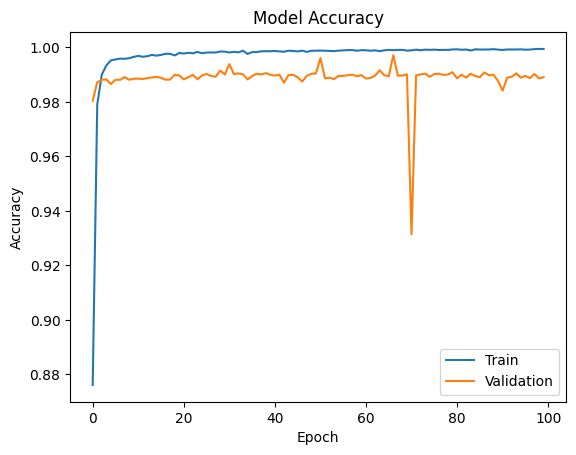

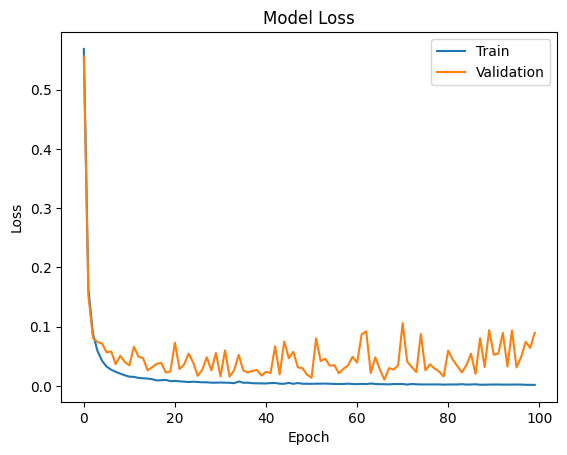

In [8]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
#plt.savefig('accHigh.svg')

# # Plot loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('lossHigh.svg')

In [9]:
model = get_model()
#load best weights from current training
model.load_weights("weights/val1-67-0.9971.hdf5")

In [10]:
preds = model.predict(XchTest)

64/64 [==============================] - 1s 3ms/step


In [11]:
print (preds.shape)

(2030, 10, 6)


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm = cm
        #print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
Yhot_pred = model.predict(XchTest)
#convert them to class numbers


64/64 [==============================] - 0s 3ms/step


In [14]:
Y_pred = np.argmax(preds, axis = 2)
Y_test = np.argmax(YhotTest, axis = 2)
print (Y_pred.shape)
print (Y_test.shape)

(2030, 10)
(2030, 10)


In [15]:
ans = 0
for i in range(Y_test.shape[0]):    
        for j in range(Y_test.shape[1]):
            if Y_test[i][j] == Y_pred[i][j]:
                ans = ans + 1    
print ("Test Accuracy Framewise is")
#print ans
print ((ans/float(Y_test.shape[0] * Y_test.shape[1]))*100 )

Test Accuracy Framewise is
98.92610837438424


In [16]:
# use polling of 15 frames to get output for the sequence
ans = 0
res = []
act = []
for i in range(Y_test.shape[0]):
    resTemp = stats.mode(Y_pred[i])
    actTemp = stats.mode(Y_test[i])
    res.append(resTemp[0][0])
    act.append(actTemp[0][0])
    if res[i] == act[i]:
        ans = ans + 1
    """for j in range(Y_test.shape[1]):
        if Y_test[i][j] != Y_pred[i][j]:
            print Y_pred[i]
            break"""
                
print ("Test Accuracy with Polling is")
#print ans
print(ans/float(Y_test.shape[0])*100)

Test Accuracy with Polling is
99.11330049261083


C:\Users\Kaustav Dasgupta\AppData\Local\Temp\ipykernel_41672\2205381928.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  resTemp = stats.mode(Y_pred[i])
C:\Users\Kaustav Dasgupta\AppData\Local\Temp\ipykernel_41672\2205381928.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid 

In [17]:
Y_pred_flat = []
Y_test_flat = []
for i in range(Y_test.shape[0]):    
        for j in range(Y_test.shape[1]):
            Y_pred_flat.append(Y_pred[i][j])
            Y_test_flat.append(Y_test[i][j])

In [18]:
print (res)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
asanas = {0:'bhujangasan', 1:'padamasan', 2:'shavasan', 3:'tadasan', 4:'trikonasan', 5:'vrikshasan'}
#uncomment for framewise
Y_asanas = np.array([asanas[a] for a in Y_test_flat])
Y_pred_asanas = np.array([asanas[a] for a in Y_pred_flat])
#Y_asanas = np.array([asanas[a] for a in act])
#Y_pred_asanas = np.array([asanas[a] for a in res])
print(Y_asanas)
print(Y_pred_asanas)

['bhujangasan' 'bhujangasan' 'bhujangasan' ... 'vrikshasan' 'vrikshasan'
 'vrikshasan']
['shavasan' 'shavasan' 'bhujangasan' ... 'vrikshasan' 'vrikshasan'
 'vrikshasan']


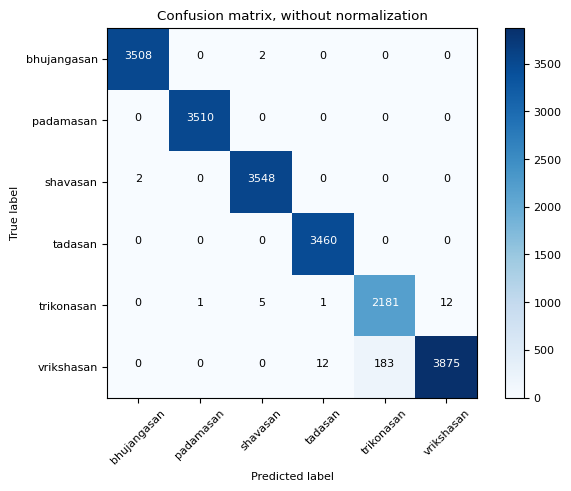

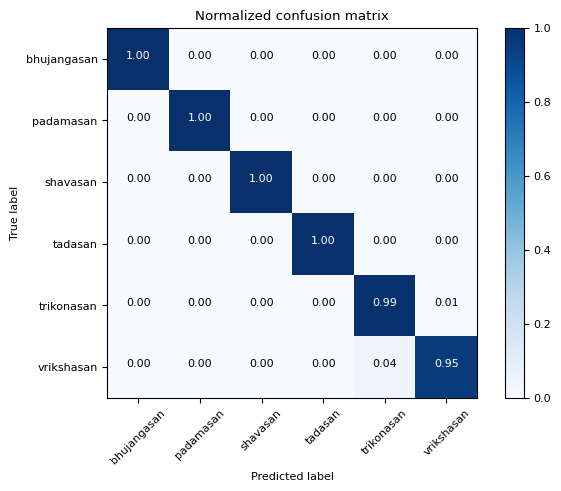

In [20]:
plt.rcParams.update({'font.size': 8})
class_names =[]
for k in range(6):
    class_names.append(asanas[k])
cnf_matrix = confusion_matrix(Y_asanas, Y_pred_asanas)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.savefig('confHighFrame.svg')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('nconfHighFrame.svg')